# HW07: Кластеризация

**Датасеты**: 01, 02, 03

**Цель**: сравнить KMeans и DBSCAN на разных типах данных, оценить качество через внутренние метрики, визуализировать через PCA, проверить устойчивость.

**Автор**: Владимир (Яков)
**Дата**: 19 января 2026

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score
)
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

In [2]:
# Создаём папки для артефактов
ARTIFACTS_DIR = Path("artifacts")
LABELS_DIR = ARTIFACTS_DIR / "labels"
FIGURES_DIR = ARTIFACTS_DIR / "figures"
ARTIFACTS_DIR.mkdir(exist_ok=True)
LABELS_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

In [3]:
# Список датасетов
datasets = {
    '01': 'data/S07-hw-dataset-01.csv',
    '02': 'data/S07-hw-dataset-02.csv',
    '03': 'data/S07-hw-dataset-03.csv'
}

all_results = []
best_configs = {}
stability_ari_all = []

In [4]:
def evaluate_clustering(X, labels, name):
    n_labels = len(np.unique(labels))
    if n_labels < 2:
        return {'model': name, 'silhouette': -1, 'ch': -1, 'db': 999}
    sil = silhouette_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    db = davies_bouldin_score(X, labels)
    return {'model': name, 'silhouette': round(sil, 4), 'ch': round(ch, 4), 'db': round(db, 4)}

In [5]:
for ds_id, path in datasets.items():
    print(f"\n=== Обработка датасета {ds_id} ===")
    
    # Загрузка данных
    df = pd.read_csv(path)
    X_raw = df.values
    
    # Препроцессинг: масштабирование обязательно!
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    
    # --- KMeans: подбор k ---
    k_range = range(2, 11)
    sil_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_k = kmeans.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels_k)
        sil_scores.append(sil)
    
    best_k = k_range[np.argmax(sil_scores)]
    kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    labels_kmeans = kmeans_best.fit_predict(X_scaled)
    
    # Проверка устойчивости KMeans (5 запусков)
    ari_scores = []
    for seed in range(5):
        km = KMeans(n_clusters=best_k, random_state=seed, n_init=10)
        l = km.fit_predict(X_scaled)
        ari = adjusted_rand_score(labels_kmeans, l)
        ari_scores.append(ari)
    stability_ari_all.extend(ari_scores)
    
    # --- DBSCAN: подбор eps ---
    eps_candidates = [0.2, 0.3, 0.4, 0.5, 0.6]
    best_eps = 0.3
    best_sil_dbscan = -2
    labels_dbscan_best = None
    
    for eps in eps_candidates:
        dbscan = DBSCAN(eps=eps, min_samples=5)
        labels_db = dbscan.fit_predict(X_scaled)
        if len(np.unique(labels_db)) < 2:
            continue
        sil_db = silhouette_score(X_scaled, labels_db)
        if sil_db > best_sil_dbscan:
            best_sil_dbscan = sil_db
            best_eps = eps
            labels_dbscan_best = labels_db
    
    if labels_dbscan_best is None:
        dbscan = DBSCAN(eps=0.3, min_samples=5)
        labels_dbscan_best = dbscan.fit_predict(X_scaled)
    
    # Оценка моделей
    metrics_kmeans = evaluate_clustering(X_scaled, labels_kmeans, 'KMeans')
    metrics_dbscan = evaluate_clustering(X_scaled, labels_dbscan_best, 'DBSCAN')
    
    all_results.append({
        'dataset': ds_id,
        'KMeans': metrics_kmeans,
        'DBSCAN': metrics_dbscan
    })
    
    best_configs[f'ds{ds_id}'] = {
        'KMeans': {'n_clusters': int(best_k)},
        'DBSCAN': {'eps': best_eps, 'min_samples': 5}
    }
    
    # Сохранение меток
    pd.Series(labels_kmeans, name='cluster').to_csv(LABELS_DIR / f'labels_hw07_ds{ds_id}.csv', index=False)
    
    # PCA для визуализации
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='tab10', s=10)
    plt.title(f'Dataset {ds_id}: KMeans (k={best_k})')
    plt.savefig(FIGURES_DIR / f'ds{ds_id}_pca_kmeans.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan_best, cmap='tab10', s=10)
    plt.title(f'Dataset {ds_id}: DBSCAN (eps={best_eps})')
    plt.savefig(FIGURES_DIR / f'ds{ds_id}_pca_dbscan.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    plt.plot(k_range, sil_scores, marker='o')
    plt.axvline(best_k, color='red', linestyle='--')
    plt.title(f'Dataset {ds_id}: Silhouette vs k')
    plt.xlabel('k')
    plt.ylabel('Silhouette Score')
    plt.savefig(FIGURES_DIR / f'ds{ds_id}_silhouette_k.png', dpi=150, bbox_inches='tight')
    plt.close()


=== Обработка датасета 01 ===

=== Обработка датасета 02 ===

=== Обработка датасета 03 ===


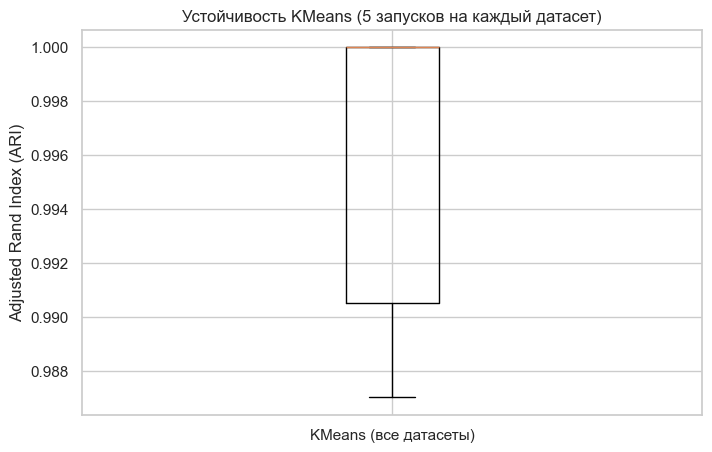

In [6]:
# Финальный график: устойчивость KMeans
plt.boxplot([stability_ari_all], labels=['KMeans (все датасеты)'])
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Устойчивость KMeans (5 запусков на каждый датасет)')
plt.savefig(FIGURES_DIR / 'stability_ari_boxplot.png', dpi=150, bbox_inches='tight')
plt.show()

In [7]:
# Сохранение артефактов
with open(ARTIFACTS_DIR / 'metrics_summary.json', 'w') as f:
    json.dump(all_results, f, indent=2)

with open(ARTIFACTS_DIR / 'best_configs.json', 'w') as f:
    json.dump(best_configs, f, indent=2)

print("\n✅ Все артефакты сохранены в artifacts/")


✅ Все артефакты сохранены в artifacts/
